In [1]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 450kB 29.8MB/s 
     |████████████████████████████████| 3.8MB 31.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


#This refers to the https://github.com/abhinav-codealchemist/Facial_Keypoint_Detection, for teaching goals, not for commercial purpose

这是一个用卷积神经网络做人脸识别的实验
数据集来源于Kaggle数据科学竞赛网站举行的某次竞赛https://www.kaggle.com/c/facial-keypoints-detection/.
同学们也可以参考这个例子：https://github.com/abhinav-codealchemist/Facial_Keypoint_Detection
x是高维度的人脸图，y是15个人脸坐标点未知的标签

In [0]:
import tensorflow

In [3]:
print(tensorflow.__version__)

2.0.0


In [0]:
# import the required packages

import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from matplotlib.patches import Circle

%matplotlib inline

#cv2是opencv的python 库，各位同学可以在本地pip install opencv-python安装，它集成了大部分2012年以前成熟的传统的计算机视觉的算法，也带有一部分深度学习的算法，如基于卷积神经网络做目标追踪

#接下来下载数据，并做预处理，图像是灰度图，一共2000张，输入为96*96*1灰度图

In [0]:
# for loading the data
def load_data(dirname, test=False):
    # read the csv data
    data = pd.read_csv(dirname)
    # drop the missing value rows 
    data = data.dropna()

    # convert the string pixels values into a matrix
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # convert the string image data to float
    imgs = np.vstack(data['Image'].values)/255
    # reshape the matrix
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # convert to float
    imgs = imgs.astype(np.float32)
    
    if test == False:
        # extract the points 
        points = data[data.columns[:-1]].values

        # scale the points [-0.5,0.5]
        points = points/96 - 0.5
        # convert it to float
        points = points.astype(np.float32)
    
    # shuffle the data
    imgs, points = shuffle(imgs, points)
    
    return imgs, points

上传本地的训练文件，西方学者一般出于半保密，会把人脸数据变成CSV格式

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


Saving training.csv to training.csv
User uploaded file "training.csv" with length 238064810 bytes


In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
User uploaded file "test.csv" with length 59822141 bytes


看下文件是否上传

In [8]:
!ls

sample_data  test.csv  training.csv


In [0]:
import pandas as pd

加载数据，同时看下训练数据和测试数据格式

In [11]:
imgs_train, points_train = load_data(dirname = 'training.csv')
imgs_test, points_test = load_data(dirname = 'test.csv')
print('Training image data: ' + str(imgs_train.shape))
print('Training points data: ' + str(points_train.shape))
print('Testing image data: ' + str(imgs_test.shape))
print('Testing points data: ' + str(points_test.shape))

Training image data: (2140, 96, 96)
Training points data: (2140, 30)
Testing image data: (1783, 96, 96)
Testing points data: (1783, 1)


数据可视化

In [0]:
# plots keypoints on face image
def plot_keypoints(img, points):
    # display image
    plt.imshow(img, cmap='gray')
    # plot the keypoints
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

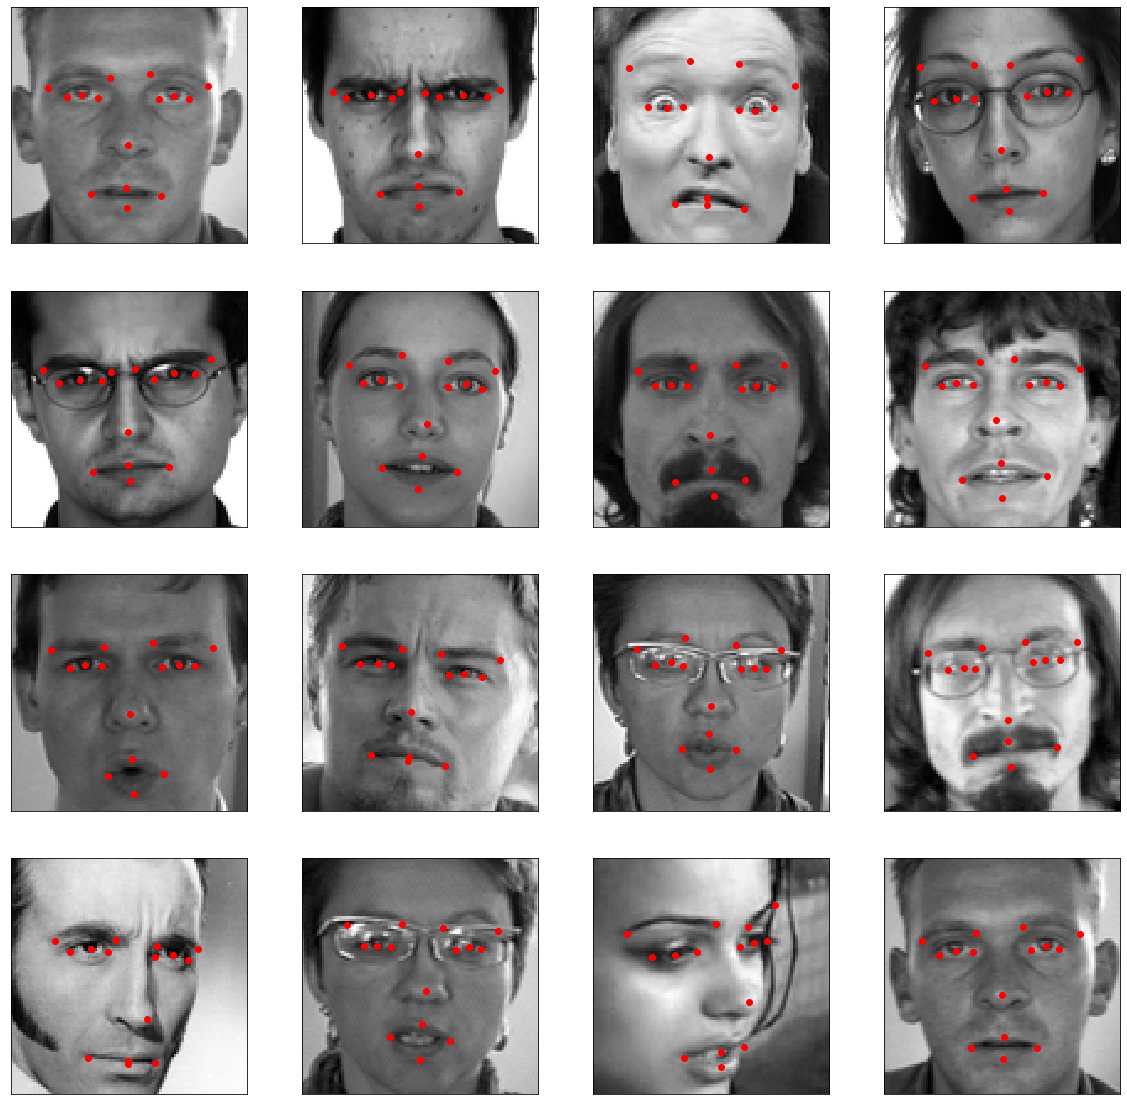

In [13]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_train[i], points_train[i])
plt.show()

数据增强，比如翻转图片，也可以尝试其他增强手段


In [0]:
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # flip the image
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # flip the points
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
        
    return new_img, new_points

深度学习为了防止过拟合，需要进行数据增强，我们在这里可以实验两种数据增方法：
1. 翻转（注意坐标位置也要flip）
2. 加噪声

In [26]:
aug_imgs_train = []
aug_points_train = []
noise = np.random.randint(5, size = (96,96), dtype = 'uint8')
# apply flipping operation
print(imgs_train.shape)
for i in tqdm(range(0,imgs_train.shape[0])):
    img_flip = np.fliplr(imgs_train[i]) #翻转
    #噪声
    img_noise = imgs_train[i]
    print(img_noise.shape)
    for i in range(96):
      for j in range(96):
          if (img_noise[i][j] != 255):
               img_noise[i][j] += noise[i][j]
    new_points = np.copy(points_train[i])
    for k in range(0,30,2):
        new_points[k] = -points_train[i][k]
    aug_imgs_train.append(img_flip)
    aug_points_train.append(new_points)
    aug_imgs_train.append(img_noise)
    aug_points_train.append(points_train[i])
    # original data
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

  0%|          | 3/2140 [00:00<01:18, 27.05it/s]

(2140, 96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  1%|          | 12/2140 [00:00<01:16, 27.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  1%|          | 18/2140 [00:00<01:16, 27.75it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  1%|          | 24/2140 [00:00<01:16, 27.67it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  1%|▏         | 31/2140 [00:01<01:13, 28.84it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  2%|▏         | 38/2140 [00:01<01:11, 29.47it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

  2%|▏         | 44/2140 [00:01<01:11, 29.40it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  2%|▏         | 50/2140 [00:01<01:11, 29.08it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  3%|▎         | 57/2140 [00:01<01:10, 29.62it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  3%|▎         | 64/2140 [00:02<01:09, 29.75it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  3%|▎         | 71/2140 [00:02<01:09, 29.73it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  4%|▎         | 78/2140 [00:02<01:08, 30.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  4%|▍         | 82/2140 [00:02<01:11, 28.70it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  4%|▍         | 89/2140 [00:03<01:09, 29.57it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  4%|▍         | 96/2140 [00:03<01:08, 29.94it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  5%|▍         | 104/2140 [00:03<01:07, 30.11it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  5%|▌         | 111/2140 [00:03<01:08, 29.60it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  5%|▌         | 117/2140 [00:04<01:09, 29.14it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  6%|▌         | 124/2140 [00:04<01:07, 29.72it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  6%|▌         | 131/2140 [00:04<01:06, 30.12it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  6%|▋         | 135/2140 [00:04<01:07, 29.51it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  7%|▋         | 141/2140 [00:04<01:09, 28.64it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  7%|▋         | 147/2140 [00:05<01:12, 27.57it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  7%|▋         | 153/2140 [00:05<01:10, 28.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  8%|▊         | 161/2140 [00:05<01:07, 29.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  8%|▊         | 169/2140 [00:05<01:05, 29.88it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  8%|▊         | 175/2140 [00:05<01:07, 29.27it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  9%|▊         | 182/2140 [00:06<01:05, 29.70it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  9%|▉         | 189/2140 [00:06<01:05, 29.98it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  9%|▉         | 197/2140 [00:06<01:04, 30.14it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


  9%|▉         | 201/2140 [00:06<01:05, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 10%|▉         | 209/2140 [00:07<01:04, 29.93it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 10%|█         | 216/2140 [00:07<01:03, 30.07it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 10%|█         | 224/2140 [00:07<01:03, 30.36it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 11%|█         | 232/2140 [00:07<01:02, 30.48it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 11%|█         | 236/2140 [00:08<01:04, 29.46it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 11%|█▏        | 242/2140 [00:08<01:09, 27.43it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 12%|█▏        | 248/2140 [00:08<01:07, 28.11it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 12%|█▏        | 254/2140 [00:08<01:07, 28.08it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 12%|█▏        | 264/2140 [00:09<01:04, 29.09it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 13%|█▎        | 271/2140 [00:09<01:03, 29.54it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 13%|█▎        | 278/2140 [00:09<01:03, 29.54it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 13%|█▎        | 281/2140 [00:09<01:04, 28.86it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 13%|█▎        | 288/2140 [00:09<01:03, 29.22it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 14%|█▍        | 295/2140 [00:10<01:02, 29.39it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 14%|█▍        | 303/2140 [00:10<01:01, 29.88it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 15%|█▍        | 311/2140 [00:10<01:00, 30.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 15%|█▍        | 319/2140 [00:10<01:00, 30.29it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 15%|█▌        | 323/2140 [00:11<01:00, 29.90it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 15%|█▌        | 330/2140 [00:11<01:00, 29.70it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 16%|█▌        | 338/2140 [00:11<01:00, 29.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 16%|█▌        | 344/2140 [00:11<01:00, 29.47it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 16%|█▋        | 350/2140 [00:11<01:01, 29.33it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 17%|█▋        | 358/2140 [00:12<00:59, 29.78it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 17%|█▋        | 366/2140 [00:12<01:00, 29.54it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 17%|█▋        | 372/2140 [00:12<01:02, 28.19it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 18%|█▊        | 378/2140 [00:12<01:02, 28.28it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 18%|█▊        | 384/2140 [00:13<01:01, 28.51it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 18%|█▊        | 391/2140 [00:13<00:59, 29.29it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 19%|█▊        | 398/2140 [00:13<00:58, 29.54it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 19%|█▉        | 404/2140 [00:13<01:01, 28.06it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 19%|█▉        | 412/2140 [00:14<00:59, 29.11it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 20%|█▉        | 420/2140 [00:14<00:57, 29.78it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 20%|█▉        | 427/2140 [00:14<00:57, 29.95it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 20%|██        | 434/2140 [00:14<00:57, 29.51it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 21%|██        | 441/2140 [00:15<00:57, 29.77it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 21%|██        | 448/2140 [00:15<00:56, 29.94it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 21%|██▏       | 455/2140 [00:15<00:56, 29.98it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 22%|██▏       | 461/2140 [00:15<00:56, 29.60it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 22%|██▏       | 468/2140 [00:15<00:56, 29.65it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 22%|██▏       | 476/2140 [00:16<00:55, 30.07it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 22%|██▏       | 480/2140 [00:16<00:55, 30.01it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 23%|██▎       | 487/2140 [00:16<00:56, 29.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 23%|██▎       | 493/2140 [00:16<00:57, 28.40it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 23%|██▎       | 499/2140 [00:17<00:57, 28.79it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 24%|██▎       | 506/2140 [00:17<00:56, 29.05it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 24%|██▍       | 513/2140 [00:17<00:55, 29.57it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 24%|██▍       | 521/2140 [00:17<00:55, 29.41it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 25%|██▍       | 528/2140 [00:17<00:54, 29.35it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 25%|██▌       | 535/2140 [00:18<00:54, 29.63it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 25%|██▌       | 543/2140 [00:18<00:53, 30.03it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 26%|██▌       | 551/2140 [00:18<00:52, 30.25it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 26%|██▌       | 555/2140 [00:18<00:52, 30.18it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 26%|██▋       | 563/2140 [00:19<00:52, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 27%|██▋       | 571/2140 [00:19<00:53, 29.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 27%|██▋       | 577/2140 [00:19<00:55, 28.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 27%|██▋       | 583/2140 [00:19<00:55, 28.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 28%|██▊       | 590/2140 [00:20<00:53, 28.81it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 28%|██▊       | 596/2140 [00:20<00:54, 28.30it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 28%|██▊       | 603/2140 [00:20<00:52, 29.05it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 28%|██▊       | 609/2140 [00:20<00:52, 29.33it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 29%|██▉       | 619/2140 [00:21<00:51, 29.69it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 29%|██▉       | 625/2140 [00:21<00:51, 29.50it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 29%|██▉       | 631/2140 [00:21<00:52, 28.62it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 30%|██▉       | 637/2140 [00:21<00:52, 28.80it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 30%|███       | 646/2140 [00:22<00:50, 29.36it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 30%|███       | 652/2140 [00:22<00:51, 28.80it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 31%|███       | 659/2140 [00:22<00:50, 29.33it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 31%|███       | 665/2140 [00:22<00:51, 28.88it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 31%|███▏      | 672/2140 [00:22<00:50, 29.26it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 32%|███▏      | 678/2140 [00:23<00:51, 28.14it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 32%|███▏      | 684/2140 [00:23<00:51, 28.46it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 32%|███▏      | 690/2140 [00:23<00:50, 28.98it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 33%|███▎      | 696/2140 [00:23<00:49, 29.11it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 33%|███▎      | 702/2140 [00:23<00:49, 28.85it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 33%|███▎      | 708/2140 [00:24<00:51, 27.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 33%|███▎      | 714/2140 [00:24<00:49, 28.76it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 34%|███▎      | 720/2140 [00:24<00:48, 29.00it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 34%|███▍      | 729/2140 [00:24<00:49, 28.46it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 34%|███▍      | 735/2140 [00:25<00:49, 28.39it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 35%|███▍      | 742/2140 [00:25<00:48, 28.68it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 35%|███▍      | 748/2140 [00:25<00:47, 29.02it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 35%|███▌      | 754/2140 [00:25<00:49, 28.12it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 36%|███▌      | 761/2140 [00:26<00:47, 28.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 36%|███▌      | 768/2140 [00:26<00:46, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 36%|███▌      | 775/2140 [00:26<00:46, 29.53it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 36%|███▋      | 781/2140 [00:26<00:46, 29.09it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 37%|███▋      | 788/2140 [00:26<00:45, 29.58it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 37%|███▋      | 795/2140 [00:27<00:44, 29.98it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 38%|███▊      | 803/2140 [00:27<00:44, 30.16it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 38%|███▊      | 811/2140 [00:27<00:44, 29.76it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 38%|███▊      | 817/2140 [00:27<00:45, 29.09it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 39%|███▊      | 824/2140 [00:28<00:44, 29.64it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 39%|███▉      | 831/2140 [00:28<00:43, 29.78it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 39%|███▉      | 838/2140 [00:28<00:43, 30.02it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 39%|███▉      | 842/2140 [00:28<00:43, 30.06it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 40%|███▉      | 850/2140 [00:29<00:42, 30.24it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 40%|████      | 857/2140 [00:29<00:43, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 40%|████      | 864/2140 [00:29<00:42, 29.75it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 41%|████      | 871/2140 [00:29<00:43, 29.02it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 41%|████      | 878/2140 [00:29<00:43, 29.26it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 41%|████▏     | 885/2140 [00:30<00:42, 29.73it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 42%|████▏     | 892/2140 [00:30<00:41, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 42%|████▏     | 900/2140 [00:30<00:40, 30.35it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 42%|████▏     | 904/2140 [00:30<00:40, 30.26it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 43%|████▎     | 911/2140 [00:31<00:41, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 43%|████▎     | 919/2140 [00:31<00:40, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 43%|████▎     | 927/2140 [00:31<00:40, 30.25it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 44%|████▎     | 935/2140 [00:31<00:40, 29.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 44%|████▍     | 939/2140 [00:32<00:40, 29.69it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 44%|████▍     | 947/2140 [00:32<00:39, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 45%|████▍     | 955/2140 [00:32<00:39, 30.20it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 45%|████▌     | 963/2140 [00:32<00:38, 30.34it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 45%|████▌     | 967/2140 [00:32<00:38, 30.20it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 46%|████▌     | 975/2140 [00:33<00:38, 30.21it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 46%|████▌     | 983/2140 [00:33<00:38, 29.81it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 46%|████▌     | 989/2140 [00:33<00:38, 29.56it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 47%|████▋     | 996/2140 [00:33<00:38, 29.87it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 47%|████▋     | 1003/2140 [00:34<00:38, 29.91it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 47%|████▋     | 1010/2140 [00:34<00:37, 30.13it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 48%|████▊     | 1018/2140 [00:34<00:37, 30.21it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 48%|████▊     | 1022/2140 [00:34<00:37, 29.93it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 48%|████▊     | 1030/2140 [00:35<00:36, 30.03it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 48%|████▊     | 1037/2140 [00:35<00:39, 28.17it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 49%|████▉     | 1044/2140 [00:35<00:37, 28.94it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 49%|████▉     | 1051/2140 [00:35<00:36, 29.52it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 49%|████▉     | 1058/2140 [00:36<00:36, 29.65it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 50%|████▉     | 1065/2140 [00:36<00:35, 29.95it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 50%|█████     | 1071/2140 [00:36<00:37, 28.77it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 50%|█████     | 1078/2140 [00:36<00:36, 29.39it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 51%|█████     | 1085/2140 [00:36<00:35, 29.56it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 51%|█████     | 1091/2140 [00:37<00:35, 29.53it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 51%|█████▏    | 1100/2140 [00:37<00:35, 29.15it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 52%|█████▏    | 1107/2140 [00:37<00:34, 29.73it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 52%|█████▏    | 1113/2140 [00:37<00:35, 29.33it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 52%|█████▏    | 1119/2140 [00:38<00:34, 29.24it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 53%|█████▎    | 1125/2140 [00:38<00:35, 28.26it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 53%|█████▎    | 1131/2140 [00:38<00:35, 28.60it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 53%|█████▎    | 1139/2140 [00:38<00:34, 29.41it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 54%|█████▎    | 1145/2140 [00:39<00:35, 27.80it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 54%|█████▍    | 1151/2140 [00:39<00:36, 27.34it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 54%|█████▍    | 1157/2140 [00:39<00:36, 27.26it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 54%|█████▍    | 1163/2140 [00:39<00:35, 27.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 55%|█████▍    | 1172/2140 [00:39<00:34, 28.43it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 55%|█████▌    | 1179/2140 [00:40<00:32, 29.20it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 55%|█████▌    | 1186/2140 [00:40<00:32, 29.24it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 56%|█████▌    | 1193/2140 [00:40<00:31, 29.82it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 56%|█████▌    | 1200/2140 [00:40<00:31, 30.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 56%|█████▋    | 1204/2140 [00:41<00:31, 30.11it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 57%|█████▋    | 1212/2140 [00:41<00:30, 30.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 57%|█████▋    | 1219/2140 [00:41<00:31, 29.16it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 57%|█████▋    | 1225/2140 [00:41<00:33, 27.72it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 58%|█████▊    | 1232/2140 [00:42<00:31, 28.73it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 58%|█████▊    | 1238/2140 [00:42<00:30, 29.18it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 58%|█████▊    | 1246/2140 [00:42<00:29, 29.82it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 59%|█████▊    | 1253/2140 [00:42<00:29, 30.01it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 59%|█████▉    | 1260/2140 [00:42<00:30, 29.11it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 59%|█████▉    | 1267/2140 [00:43<00:29, 29.58it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 60%|█████▉    | 1274/2140 [00:43<00:28, 29.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 60%|█████▉    | 1282/2140 [00:43<00:28, 30.15it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 60%|██████    | 1286/2140 [00:43<00:28, 30.11it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 60%|██████    | 1294/2140 [00:44<00:28, 30.05it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 61%|██████    | 1302/2140 [00:44<00:27, 30.27it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 61%|██████    | 1310/2140 [00:44<00:27, 30.44it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 61%|██████▏   | 1314/2140 [00:44<00:27, 30.09it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 62%|██████▏   | 1322/2140 [00:45<00:27, 29.82it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 62%|██████▏   | 1329/2140 [00:45<00:27, 30.01it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 62%|██████▏   | 1337/2140 [00:45<00:26, 30.20it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 63%|██████▎   | 1345/2140 [00:45<00:26, 30.36it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 63%|██████▎   | 1349/2140 [00:45<00:27, 28.42it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 63%|██████▎   | 1357/2140 [00:46<00:26, 29.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 64%|██████▎   | 1364/2140 [00:46<00:26, 29.69it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 64%|██████▍   | 1371/2140 [00:46<00:26, 29.54it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 64%|██████▍   | 1378/2140 [00:46<00:26, 29.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 65%|██████▍   | 1385/2140 [00:47<00:25, 29.68it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 65%|██████▌   | 1392/2140 [00:47<00:24, 29.98it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 65%|██████▌   | 1400/2140 [00:47<00:24, 30.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 66%|██████▌   | 1404/2140 [00:47<00:24, 30.19it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 66%|██████▌   | 1411/2140 [00:48<00:24, 29.74it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 66%|██████▋   | 1419/2140 [00:48<00:23, 30.09it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 67%|██████▋   | 1427/2140 [00:48<00:24, 29.39it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 67%|██████▋   | 1434/2140 [00:48<00:23, 29.76it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 67%|██████▋   | 1441/2140 [00:49<00:23, 30.00it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 68%|██████▊   | 1445/2140 [00:49<00:23, 29.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 68%|██████▊   | 1453/2140 [00:49<00:22, 30.27it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 68%|██████▊   | 1461/2140 [00:49<00:22, 30.03it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 69%|██████▊   | 1469/2140 [00:49<00:22, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 69%|██████▉   | 1473/2140 [00:50<00:23, 28.91it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 69%|██████▉   | 1479/2140 [00:50<00:22, 29.15it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 69%|██████▉   | 1487/2140 [00:50<00:21, 29.85it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 70%|██████▉   | 1494/2140 [00:50<00:21, 30.00it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 70%|███████   | 1502/2140 [00:51<00:21, 30.27it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 71%|███████   | 1510/2140 [00:51<00:20, 30.03it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 71%|███████   | 1514/2140 [00:51<00:21, 29.44it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 71%|███████   | 1521/2140 [00:51<00:21, 28.76it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 71%|███████▏  | 1529/2140 [00:52<00:20, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 72%|███████▏  | 1536/2140 [00:52<00:20, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 72%|███████▏  | 1543/2140 [00:52<00:19, 29.90it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 72%|███████▏  | 1551/2140 [00:52<00:19, 30.22it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 73%|███████▎  | 1559/2140 [00:53<00:19, 30.28it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 73%|███████▎  | 1563/2140 [00:53<00:19, 30.27it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 73%|███████▎  | 1571/2140 [00:53<00:18, 30.44it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 74%|███████▍  | 1579/2140 [00:53<00:18, 30.52it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 74%|███████▍  | 1587/2140 [00:53<00:18, 30.52it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 74%|███████▍  | 1591/2140 [00:54<00:18, 29.73it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 75%|███████▍  | 1599/2140 [00:54<00:17, 30.15it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 75%|███████▌  | 1607/2140 [00:54<00:17, 29.78it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 75%|███████▌  | 1613/2140 [00:54<00:17, 29.70it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 76%|███████▌  | 1619/2140 [00:55<00:18, 28.72it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 76%|███████▌  | 1626/2140 [00:55<00:17, 29.49it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 76%|███████▋  | 1633/2140 [00:55<00:17, 29.59it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 77%|███████▋  | 1640/2140 [00:55<00:16, 29.80it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 77%|███████▋  | 1647/2140 [00:55<00:16, 29.63it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 77%|███████▋  | 1653/2140 [00:56<00:17, 28.05it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 77%|███████▋  | 1656/2140 [00:56<00:18, 26.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 78%|███████▊  | 1663/2140 [00:56<00:17, 27.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 78%|███████▊  | 1670/2140 [00:56<00:16, 28.73it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 78%|███████▊  | 1677/2140 [00:57<00:15, 29.08it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 79%|███████▊  | 1685/2140 [00:57<00:15, 29.80it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 79%|███████▉  | 1692/2140 [00:57<00:14, 29.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 79%|███████▉  | 1700/2140 [00:57<00:14, 30.19it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 80%|███████▉  | 1707/2140 [00:58<00:14, 29.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 80%|████████  | 1714/2140 [00:58<00:14, 29.70it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 80%|████████  | 1721/2140 [00:58<00:13, 29.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 81%|████████  | 1729/2140 [00:58<00:13, 30.24it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 81%|████████  | 1733/2140 [00:58<00:13, 30.07it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 81%|████████▏ | 1741/2140 [00:59<00:13, 29.51it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 82%|████████▏ | 1748/2140 [00:59<00:13, 29.46it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 82%|████████▏ | 1755/2140 [00:59<00:12, 29.84it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 82%|████████▏ | 1762/2140 [00:59<00:12, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 83%|████████▎ | 1770/2140 [01:00<00:12, 30.24it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 83%|████████▎ | 1774/2140 [01:00<00:12, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 83%|████████▎ | 1782/2140 [01:00<00:11, 30.29it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 84%|████████▎ | 1790/2140 [01:00<00:11, 30.41it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 84%|████████▍ | 1794/2140 [01:00<00:11, 30.20it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 84%|████████▍ | 1801/2140 [01:01<00:11, 29.80it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 85%|████████▍ | 1809/2140 [01:01<00:11, 29.75it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 85%|████████▍ | 1816/2140 [01:01<00:10, 30.02it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 85%|████████▌ | 1824/2140 [01:01<00:10, 30.10it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 86%|████████▌ | 1831/2140 [01:02<00:10, 29.06it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 86%|████████▌ | 1838/2140 [01:02<00:10, 29.56it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 86%|████████▌ | 1845/2140 [01:02<00:09, 29.96it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 86%|████████▋ | 1851/2140 [01:02<00:09, 29.41it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 87%|████████▋ | 1858/2140 [01:03<00:09, 29.16it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 87%|████████▋ | 1864/2140 [01:03<00:09, 28.69it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 87%|████████▋ | 1870/2140 [01:03<00:09, 27.45it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 88%|████████▊ | 1873/2140 [01:03<00:09, 26.84it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 88%|████████▊ | 1880/2140 [01:03<00:09, 28.42it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 88%|████████▊ | 1888/2140 [01:04<00:08, 29.45it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 89%|████████▊ | 1895/2140 [01:04<00:08, 29.88it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 89%|████████▉ | 1902/2140 [01:04<00:07, 30.13it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 89%|████████▉ | 1910/2140 [01:04<00:07, 29.84it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 90%|████████▉ | 1917/2140 [01:05<00:07, 30.04it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 90%|████████▉ | 1925/2140 [01:05<00:07, 29.99it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 90%|█████████ | 1929/2140 [01:05<00:07, 29.86it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 91%|█████████ | 1937/2140 [01:05<00:06, 30.21it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 91%|█████████ | 1945/2140 [01:06<00:06, 30.30it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 91%|█████████▏| 1953/2140 [01:06<00:06, 30.48it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)

 91%|█████████▏| 1957/2140 [01:06<00:06, 30.41it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 92%|█████████▏| 1965/2140 [01:06<00:05, 30.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 92%|█████████▏| 1972/2140 [01:06<00:05, 29.36it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 92%|█████████▏| 1979/2140 [01:07<00:05, 29.79it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 93%|█████████▎| 1985/2140 [01:07<00:05, 29.75it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 93%|█████████▎| 1992/2140 [01:07<00:04, 29.96it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 93%|█████████▎| 1999/2140 [01:07<00:04, 30.13it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 94%|█████████▍| 2007/2140 [01:08<00:04, 29.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 94%|█████████▍| 2014/2140 [01:08<00:04, 29.61it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 94%|█████████▍| 2020/2140 [01:08<00:04, 29.30it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 95%|█████████▍| 2027/2140 [01:08<00:03, 29.72it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 95%|█████████▌| 2034/2140 [01:09<00:03, 29.76it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 95%|█████████▌| 2041/2140 [01:09<00:03, 29.97it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 96%|█████████▌| 2048/2140 [01:09<00:03, 30.16it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 96%|█████████▌| 2052/2140 [01:09<00:02, 30.20it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 96%|█████████▋| 2060/2140 [01:09<00:02, 30.06it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 97%|█████████▋| 2068/2140 [01:10<00:02, 30.20it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 97%|█████████▋| 2072/2140 [01:10<00:02, 30.22it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 97%|█████████▋| 2080/2140 [01:10<00:01, 30.23it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 98%|█████████▊| 2088/2140 [01:10<00:01, 30.31it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 98%|█████████▊| 2095/2140 [01:11<00:01, 29.42it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 98%|█████████▊| 2101/2140 [01:11<00:01, 28.78it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 99%|█████████▊| 2108/2140 [01:11<00:01, 29.46it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 99%|█████████▉| 2115/2140 [01:11<00:00, 29.93it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 99%|█████████▉| 2118/2140 [01:11<00:00, 27.41it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


 99%|█████████▉| 2126/2140 [01:12<00:00, 29.02it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


100%|█████████▉| 2133/2140 [01:12<00:00, 29.72it/s]

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


100%|██████████| 2140/2140 [01:12<00:00, 30.17it/s]


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(6420, 96, 96)
(6420, 30)


完成预处理之后，准备训练

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [0]:
# reshape the images for training
aug_imgs_train = aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1)
imgs_test = imgs_test.reshape(imgs_test.shape[0], 96, 96, 1)

In [37]:
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

# model architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(30))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [38]:
# training the model
hist = model.fit(aug_imgs_train, aug_points_train, validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
          shuffle=True, epochs=150, verbose=1)

# save the model weights
model.save_weights('face_weights.h5')


Train on 5136 samples, validate on 1284 samples
Epoch 1/150
5120/5136 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.7607
Epoch 00001: val_loss improved from inf to 0.00013, saving model to best_weights.h5
5136/5136 [==============================] - 47s 9ms/sample - loss: 0.0062 - accuracy: 0.7615 - val_loss: 1.3149e-04 - val_accuracy: 1.0000
Epoch 2/150
5120/5136 [============================>.] - ETA: 0s - loss: 6.7461e-04 - accuracy: 0.9428
Epoch 00002: val_loss improved from 0.00013 to 0.00001, saving model to best_weights.h5
5136/5136 [==============================] - 46s 9ms/sample - loss: 6.7413e-04 - accuracy: 0.9428 - val_loss: 1.3638e-05 - val_accuracy: 1.0000
Epoch 3/150
5120/5136 [============================>.] - ETA: 0s - loss: 4.5312e-04 - accuracy: 0.9803
Epoch 00003: val_loss did not improve from 0.00001
5136/5136 [==============================] - 46s 9ms/sample - loss: 4.5286e-04 - accuracy: 0.9803 - val_loss: 2.9928e-05 - val_accuracy: 1.0